In [431]:
import inputs
import refdata as ref
import numpy
from scipy import interpolate
from isentropic_efficiency import getefficiency
import pandas as pd
import matplotlib.pyplot as plt
import math

In [432]:
inputs.refrigerant

'r744'

In [433]:
# Get evaporator temperature

if inputs.source_type == 'Air':
    evaporator_temp = inputs.source_temp - 6
elif inputs.source_type == 'Water':
    evaporator_temp = inputs.source_temp - 6
elif inputs.source_type == 'Advanced':
    evaporator_temp = inputs.source_temp - inputs.delta_T_source_evaporator

In [434]:
# Get condensor temperature

if inputs.sink_type == 'Air':
    condensor_temp = inputs.sink_temp + 12

elif inputs.sink_type == 'Water':
    delta_T_sink_condensor = 5
    supply_temp = inputs.sink_temp
    return_temp = inputs.sink_temp_return

    condensor_temp = (-(return_temp-supply_temp*numpy.exp((supply_temp
                      - return_temp)/delta_T_sink_condensor)) / (numpy.exp(
                      (supply_temp-return_temp) / delta_T_sink_condensor)-1)) \
                       + delta_T_sink_condensor

elif inputs.sinkType == 'Advanced':
    condensor_temp = inputs.sink_temp + inputs.delta_T_sink_condensor

In [435]:
# Compressor intake (suction line)
p1 = ref.pressure_saturated_liq_func(evaporator_temp)[()]
t1 = evaporator_temp + inputs.delta_T_superheat_suction
h1 = ref.enthalpy_superheated_func(inputs.delta_T_superheat_suction, p1)[0]

In [436]:
p1

33.9726

In [437]:
s1 = interpolate.bisplev(inputs.delta_T_superheat_suction, p1, ref.entropy_superheated_func)

if inputs.delta_T_superheat_suction == 0:
    x1 = 1
else:
    x1 = '-'

In [438]:
# Compressor output (isentropic)
p2s = ref.pressure_saturated_gas_func(condensor_temp)
s2s = s1
dt2s = interpolate.bisplev(s2s, p2s, ref.dt_s_superheated_func)
t2s = condensor_temp + dt2s
x2s = '-'
h2s = ref.enthalpy_superheated_func(dt2s, p2s)[0]

In [439]:
pressureratio = p2s/p1
ideal = inputs.ideal_pressure_ratio

In [440]:
# Used to be in seperate file

if inputs.isentropic_efficiency == 'Estimate':
    if inputs.compressor_type == 'Screw':
            isentropic_efficiency_max = 0.75
    elif inputs.compressor_type == 'Scroll':
         isentropic_efficiency_max = 0.73
    elif inputs.compressor_type == 'Reciprocating':
         isentropic_efficiency_max = 0.72
    elif inputs.compressor_type == 'Centrifugal':
        isentropic_efficiency_max = 0.77
    elif inputs.compressor_type == 'Unknown':
         isentropic_efficiency_max = 0.70

    delta = pressureratio - inputs.ideal_pressure_ratio
    isentropic_efficiency = -0.01 * math.pow(delta, 2) + isentropic_efficiency_max

elif inputs.isentropic_efficiency == 'Value':
        isentropic_efficiency = inputs.isentropic_efficiency_val/100

elif inputs.isentropic_efficiency == 'Do not include in calculation':
        isentropic_efficiency = 1

In [441]:
# Compressor output ('real')
# isentropic_efficiency = isen.getefficiency(p2s/p1)

p2 = p2s
h2 = h1 + (h2s-h1) / isentropic_efficiency
dt2 = interpolate.bisplev(h2, p2, ref.dt_h_superheated_func)
t2 = condensor_temp + dt2
s2 = interpolate.bisplev(dt2, p2, ref.entropy_superheated_func)[()]
x2 = '-'

In [442]:
# Expansion valve intake
p3 = p2

if ref.temp_gas_saturated.equals(ref.temp_liquid_saturated):
    zeotropic = False
    t3 = condensor_temp
else: 
    zeotropic = True
    t3 = ref.temp_liquid_saturated_func(p2)

h3 = ref.enthalpy_liquid_saturated_func(p3)
s3 = ref.entropy_liquid_saturated_func(p3)
x3 = 0

In [443]:
# Expansion valve outlet
p4 = p1
t4 = evaporator_temp
h4 = h3

hf = ref.enthalpy_liquid_saturated_func(p4)
hg = ref.enthalpy_gas_saturated_func(p1)
x4 = (h4-hf) / (hg-hf)

sf = ref.entropy_liquid_saturated_func(p4)
sg = ref.entropy_gas_saturated_func(p1)
s4 = sf + x4 * (sg-sf)

In [444]:
# Cop calculation
delta_h_compressor = (h2-h1) / (inputs.motor_efficiency/100)
delta_h_condensor = h2-h3
cop = delta_h_condensor/delta_h_compressor
cop_carnot = (condensor_temp+273.15) / (condensor_temp-evaporator_temp)
carnot_efficiency = cop / cop_carnot

In [445]:
cop

4.411955887136865

In [446]:
# Creating table
table = pd.DataFrame([['1',t1, p1, h1, s1, x1], 
                    ['2s', t2s, p2s, h2s, s2s, x2s], 
                    ['2', t2, p2, h2, s2, x2], 
                    ['3', t3, p3, h3, s3, x3], 
                    ['4', t4, p4, h4, s4, x4]])
table.columns = ['point', 'T (deg. C)', 'p (bar)', 'h (kJ/kg)', 
                's (kJ/kgK)', 'x']

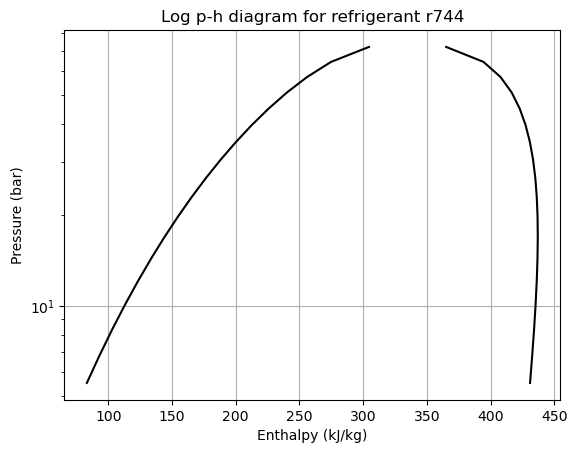

In [447]:
#plot log p-h saturation curve

fig, ax = plt.subplots()

toplot_h_liq = ref.enthalpy_liquid_saturated_func(ref.pressure_saturated)
toplot_h_gas = ref.enthalpy_gas_saturated_func(ref.pressure_saturated)
toplot_p = ref.pressure_saturated

ax.plot(toplot_h_liq, toplot_p, color='k')
ax.plot(toplot_h_gas, toplot_p, color='k')

plt.yscale('log')
plt.xlabel("Enthalpy (kJ/kg)")
plt.ylabel("Pressure (bar)")
plt.title("Log p-h diagram for refrigerant " + inputs.refrigerant)
plt.grid()

In [448]:
inputs.refrigerant

'r744'

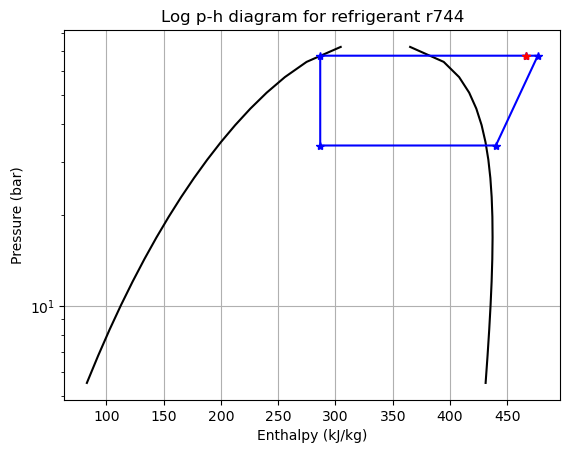

In [449]:
# Plot cycle

ax.plot(table['h (kJ/kg)'] , table['p (bar)'], '*b')
ax.plot([h1,h2,h3,h4,h1] , [p1,p2,p3,p4,p1], 'b')
ax.plot(h2s,p2s, '*r')
fig

In [450]:
# Flow rates etc

mass_flowrate_refrigerant = inputs.capacity/delta_h_condensor   	#kg/s
RHO_C = 4000
volume_rate_water = inputs.capacity / ((inputs.sink_temp - inputs.sink_temp_return)*RHO_C)
electric_power = inputs.capacity/cop

In [451]:
table

,point,T (deg. C),p (bar),h (kJ/kg),s (kJ/kgK),x
0,1,4.000000,33.9726,439.932061,1.876243,-
1,2s,54.762169,67.46,466.251278,1.876243,-
2,2,61.223251,67.46,476.501141,1.917049,-
3,3,27.000000,67.46,286.688,1.286,0
4,4,-1.000000,33.9726,286.688,1.318834,0.381037


In [452]:
# print(zeotropic)
# plt.show()
# print(cop)
# print(cop_carnot)
# print(carnot_efficiency)
# print(table)